# Receding Horizon

This notebook is your playground to pull together techniques from the previous lessons! A solution here can be built from previous solutions (more or less) so we will offer no solution notebook this time.

Here's a suggested approach:

1. Load the colliders data
2. Discretize your search space into a grid or graph
3. Define a start and goal location
4. Find a coarse 2D plan from start to goal
5. Choose a location along that plan and discretize
   a local volume around that location (for example, you
   might try a 40x40 m area that is 10 m high discretized
   into 1m^3 voxels)
6. Define your goal in the local volume to a a node or voxel
   at the edge of the volume in the direction of the next
   waypoint in your coarse global plan.
7. Plan a path through your 3D grid or graph to that node
   or voxel at the edge of the local volume.  

We'll import some of the routines from previous exercises that you might find useful here.  

In [3]:
import matplotlib.pyplot as plt
from bresenham import bresenham
from scipy.spatial import Voronoi, voronoi_plot_2d
import networkx as nx
import numpy.linalg as LA
from queue import PriorityQueue
from shapely.geometry import Polygon, Point, LineString
from grid import create_grid, create_grid_bfs
import time
from sklearn.neighbors import KDTree
import numpy as np
from skimage.morphology import medial_axis
from skimage.util import invert
from planning import a_star, breadth_first, a_star_bfs
from planning import heuristic_euclidean, heuristic_manhattan

%matplotlib inline

In [4]:
plt.rcParams['figure.figsize'] = 14, 14

## Load Data and Functions

In [5]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [6]:
def find_start_goal(skel, start, goal):
    
    skel_cells = np.transpose(skel.nonzero())
    start_min_dist = np.linalg.norm(np.array(start) - np.array(skel_cells), axis=1).argmin()
    near_start = skel_cells[start_min_dist]
    goal_min_dist = np.linalg.norm(np.array(goal) - np.array(skel_cells), axis=1).argmin()
    near_goal = skel_cells[goal_min_dist]
    
    return near_start, near_goal

In [7]:
def prune_path_bres(path, grid, goal):
    
    pruned_path = [p for p in path]
    i = 0
    
    while i < len(pruned_path) - 2:
        p1 = pruned_path[i]
        p2 = pruned_path[i+2]
        k = 0
        
        cells = list(bresenham(int(p1[0]), int(p1[1]), int(p2[0]), int(p2[1])))
        
        for c in cells:
            k += grid[c]
            
        if k > 0:
            i += 1
        else:
            pruned_path.remove(pruned_path[i+1])
        
    pruned_path.append(goal)
    
    return pruned_path    

# Global Path

In [22]:
start_ne = (20,  710)
goal_ne = (750., 800.)
# Static drone altitude (meters)
drone_altitude = 25
safety_distance = 2
grid = create_grid_bfs(data, drone_altitude, safety_distance)
skeleton = medial_axis(invert(grid))

skel_start, skel_goal = find_start_goal(skeleton, start_ne, goal_ne)


In [23]:
#print(grid[0:][0])
#print(grid[0:][-1])
#print(grid[0][0:])
#print(grid[-1][0:])

In [27]:
t0 = time.time()

mapa = breadth_first(invert(skeleton).astype(np.int), tuple(skel_goal), tuple(skel_start))
#print(mapa)

time_taken = time.time() - t0
print("Time taken {0} seconds ...", time_taken)


Found a path.
926.4499269370598
Time taken {0} seconds ... 0.31324219703674316


In [28]:
t0 = time.time()

path, cost, steps = a_star(invert(skeleton).astype(np.int), heuristic_euclidean, tuple(skel_start), tuple(skel_goal))

time_taken = time.time() - t0
print("Time taken {0} seconds ...", time_taken)
path3 = prune_path_bres(path, grid, tuple(skel_goal))


Found a path.
Time taken {0} seconds ... 0.13440847396850586


In [30]:
t0 = time.time()

path2, cost, steps = a_star_bfs(invert(skeleton).astype(np.int), mapa, tuple(skel_start), tuple(skel_goal))

time_taken = time.time() - t0
print("Time taken {0} seconds ...", time_taken)
path4 = prune_path_bres(path2, grid, tuple(skel_goal))


Found a path.
Time taken {0} seconds ... 0.026190757751464844


In [18]:
len(mapa)

851929

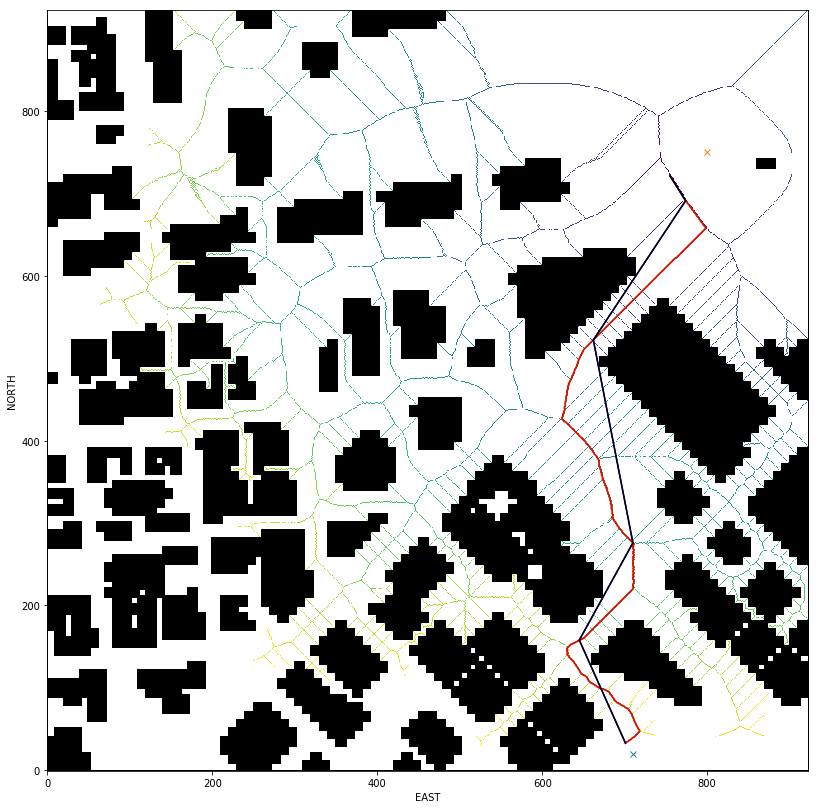

In [31]:
plt.imshow(grid,cmap='Greys' ,origin='lower')
mapa2d = np.zeros(np.shape(grid))
for i in range(len(mapa)):
    x = i % np.shape(grid)[1]
    y = i // np.shape(grid)[1]
    mapa2d[x,y] = mapa[i]
plt.imshow(mapa2d, origin='lower')

#plt.imshow(skeleton, cmap='Greys', origin='lower', alpha=0.7)
# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.
plt.plot(710, 20, 'x')
# Uncomment the following as needed
plt.plot(goal_ne[1], goal_ne[0], 'x')


pp = np.array(path)
plt.plot(pp[:, 1], pp[:, 0], 'g')
pp2 = np.array(path2)
plt.plot(pp2[:, 1], pp2[:, 0], 'r')
pp = np.array(path3)
plt.plot(pp[:, 1], pp[:, 0], 'B')
pp2 = np.array(path4)
plt.plot(pp2[:, 1], pp2[:, 0], 'K')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

global_path = path2

# Local Path

In [156]:
def create_voxmap(origin, length, height, voxel_size, grid):
    """
    Returns a grid representation of a 3D configuration space
    based on given obstacle data.
    
    The `voxel_size` argument sets the resolution of the voxel map. 
    """

    d_length = int(np.ceil(length)) // 2 // voxel_size
    d_height = int(height) // 2  // voxel_size

    voxmap = np.zeros((length, length, height), dtype=np.bool)

    for i in range(length):
        for j in range(length):
            if(grid[origin[0] - d_length + i][origin[1] - d_length + j] > 0):
                voxmap[i][j][:] = True
        
        
    return voxmap

In [169]:
# minimum and maximum north coordinates
north_min = np.floor(np.amin(data[:, 0] - data[:, 3]))
north_max = np.ceil(np.amax(data[:, 0] + data[:, 3]))

# minimum and maximum east coordinates
east_min = np.floor(np.amin(data[:, 1] - data[:, 4]))
east_max = np.ceil(np.amax(data[:, 1] + data[:, 4]))

alt_max = np.ceil(np.amax(data[:, 2] + data[:, 5]))
    
print(north_min, east_min)
origin = (380, 675, 5)
voxmap = create_voxmap(origin, 40, 10, 1, grid)
print(voxmap.shape)

path_3d = a_star

-316.0 -445.0
(40, 40, 10)


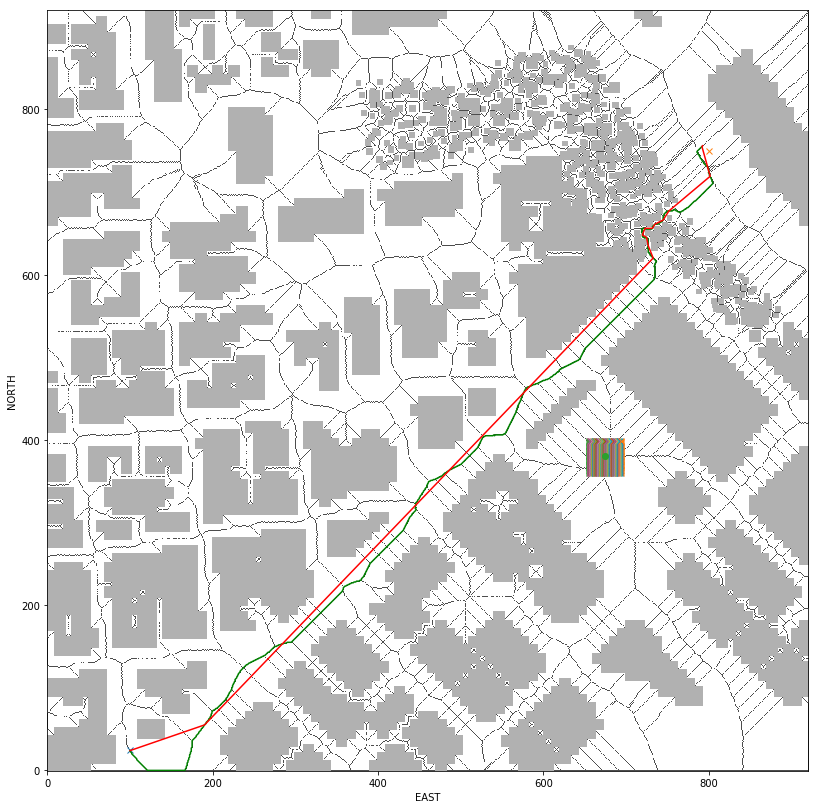

In [168]:
plt.imshow(grid, cmap='Greys', origin='lower')
plt.imshow(skeleton, cmap='Greys', origin='lower', alpha=0.7)
# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.
plt.plot(start_ne[1], start_ne[0], 'x')
# Uncomment the following as needed
plt.plot(goal_ne[1], goal_ne[0], 'x')

for x in range(voxmap.shape[0]):
    for y in range(voxmap.shape[1]):
        plt.plot(y+origin[1]-20, x+origin[0]-20, 'x')

plt.plot(675, 380, 'o')

        
pp = np.array(path)
plt.plot(pp[:, 1], pp[:, 0], 'g')
pp2 = np.array(path2)
plt.plot(pp2[:, 1], pp2[:, 0], 'r')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()